In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

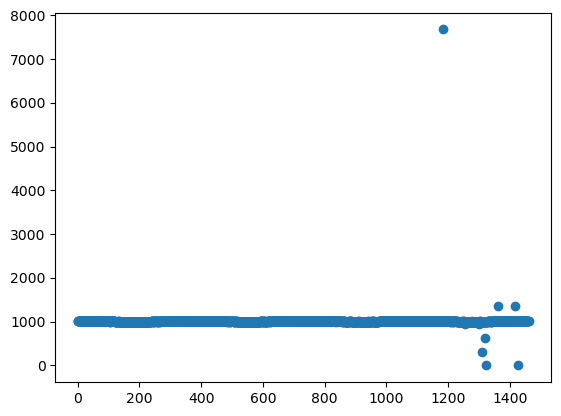

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


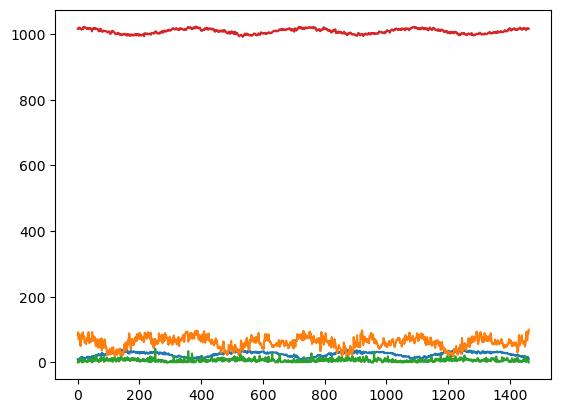

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

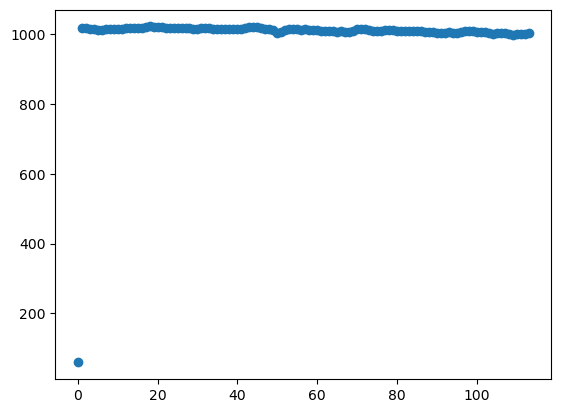

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

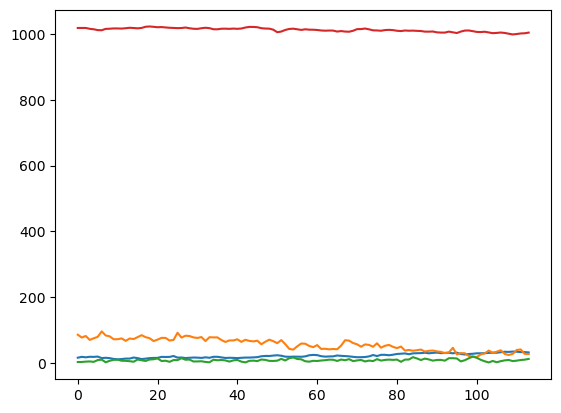

In [16]:
plt.plot(test)

## 1.2 Add Gauss Noise

In [17]:
import random

In [27]:
train_noised = train.copy()

In [28]:
for i in range(len(train_noised)):
    for j in range(4):
        train_noised.iloc[i][j] += random.gauss(0, 10)

In [29]:
train.iloc[2]

meantemp           7.166667
humidity          87.000000
wind_speed         4.633333
meanpressure    1018.666667
Name: 2, dtype: float64

In [30]:
train_noised.iloc[2]

meantemp           8.232968
humidity          92.429224
wind_speed         5.482469
meanpressure    1005.933365
Name: 2, dtype: float64

## 1.2 Transfer data to LSTM representation

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [33]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [34]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

train_processed_noised, train_scaler_noised = data_process(train_noised, window_size, predict_size)
X_train_noised, y_train_noised = train_processed_noised['datain'], train_processed_noised['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [35]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train_noised = torch.from_numpy(X_train_noised.astype(np.float32))
y_train_noised = torch.from_numpy(y_train_noised.astype(np.float32))

### - data loader

In [36]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
train_data_noised = Data.TensorDataset(X_train_noised, y_train_noised)
test_data = Data.TensorDataset(X_test, y_test)

In [37]:
print(f'size of train_data: {len(train_data)}')
print(f'size of train_data_noised: {len(train_data_noised)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of train_data_noised: 5832
size of test_data: 440


In [38]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [39]:
train_data_noised[0]

(tensor([-0.6229, -0.5173, -0.6599,  1.7836, -0.6542, -0.4772, -0.6678,  1.7952,
         -0.6300, -0.4314, -0.6365,  1.7239]),
 tensor([-0.6273, -0.4690, -0.6707,  1.7312]))

In [40]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [41]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [42]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [43]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [44]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [45]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [46]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [47]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [48]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        [ vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            [ vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        return vqc

## 2.3 Quantum-LSTM

In [49]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [50]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [51]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__(input_size, hidden_size, ctx = ctx)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

In [52]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
}

## 2.4 Stacked QLSTM

In [53]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical'):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [54]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

In [55]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical'):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [56]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {step + 1}/{epoch}: Loss: {train_loss / batch_size}')
        losses.append(train_loss / batch_size)
    
    return losses

## 3.2 Evaluate Model

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae])

## 3.3 Train Model

In [58]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [59]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

### - classical LSTM

In [63]:
model = Model(input_size, hidden_size, num_output, 
                num_layers = num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(model, train_data_noised, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 100)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/100: Loss: 1.0229172378778457
Epoch 2/100: Loss: 0.9781067162752152
Epoch 3/100: Loss: 1.00921688079834
Epoch 4/100: Loss: 1.0056479185819627
Epoch 5/100: Loss: 0.9684818506240844
Epoch 6/100: Loss: 0.9772185206413269
Epoch 7/100: Loss: 0.9617348551750183
Epoch 8/100: Loss: 0.9291617333889007
Epoch 9/100: Loss: 0.9324385553598404
Epoch 10/100: Loss: 0.8923469543457031
Epoch 11/100: Loss: 0.8947502434253692
Epoch 12/100: Loss: 0.8578714579343796
Epoch 13/100: Loss: 0.8047020435333252
Epoch 14/100: Loss: 0.7692150712013245
Epoch 15/100: Loss: 0.735347780585289
Epoch 16/100: Loss: 0.6929446429014205
Epoch 17/100: Loss: 0.6696116834878921
Epoch 18/100: Loss: 0.5737054541707038
Epoch 19/100: Loss: 0.5114185109734535
Epoch 20/100: Loss: 0.47856389731168747
Epoch 21/100: Loss: 0.3979611977934837
Epoch 22/100: Loss: 0.372885224968195
Epoch 23/100: Loss: 0.3378752827644348
Epoch 24/100: Loss: 0.3043385915458202
Epoch 25/100: Loss: 0.2665554001927376
Epoch 26/100: Loss: 0.192116529867053

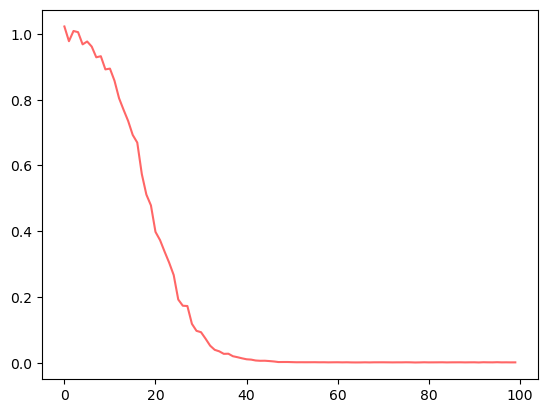

In [64]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [65]:
calculate_accuarcy(model, X_test, y_test)

array([ 98.37791827,  10.80786741, 116.80999787,   8.40795552])

In [80]:
# array([ 98.52209099,  10.03566763, 100.71462476,   7.66064557])

### - QLSTM

In [66]:
qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='classical')
optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(qmodel, train_data_noised, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 50)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/50: Loss: 0.9592711597681045
Epoch 2/50: Loss: 1.005756178498268
Epoch 3/50: Loss: 1.0028739631175996
Epoch 4/50: Loss: 0.9175043880939484
Epoch 5/50: Loss: 0.8762839704751968
Epoch 6/50: Loss: 0.8096114814281463
Epoch 7/50: Loss: 0.6371553272008896
Epoch 8/50: Loss: 0.5984042584896088
Epoch 9/50: Loss: 0.39748686626553537
Epoch 10/50: Loss: 0.42880500219762324
Epoch 11/50: Loss: 0.33106919191777706
Epoch 12/50: Loss: 0.2531758569180965
Epoch 13/50: Loss: 0.3117361430078745
Epoch 14/50: Loss: 0.14505491917952895
Epoch 15/50: Loss: 0.14971332717686892
Epoch 16/50: Loss: 0.1002045120112598
Epoch 17/50: Loss: 0.09721009940840304
Epoch 18/50: Loss: 0.05286703517194837
Epoch 19/50: Loss: 0.021109139552572743
Epoch 20/50: Loss: 0.010864466583007016
Epoch 21/50: Loss: 0.003661282124812715
Epoch 22/50: Loss: 0.0022269328157562994
Epoch 23/50: Loss: 0.0013926488347351551
Epoch 24/50: Loss: 0.0014182654893375001
Epoch 25/50: Loss: 0.00136905500330613
Epoch 26/50: Loss: 0.0012871508159150

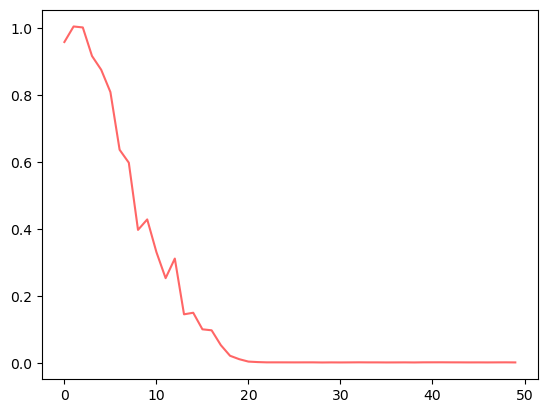

In [67]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [68]:
calculate_accuarcy(qmodel, X_test, y_test)

array([98.6215952 ,  8.51798593, 72.55608424,  7.14487193])

In [84]:
with open('loss/noise/loss4.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [89]:
average_accuracy = np.mean([
    0.9808, 0.9839, 0.9791, 0.9832, 0.9712
])
average_accuracy

0.9796400000000001

In [85]:
average_time = np.mean([
    167.10324335098267, 169.0270173549652, 169.0270173549652, 169.0270173549652
])
average_time

168.54607385396957

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [447]:
# save the model
torch.save(qmodel.state_dict(), "model/qmodel_GRU.pt")